# Sentiment Analysis
#### Creating a sentiment analysis model that can predict if tweets/reddit comments are positive, netural or negative.

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import tensorflow as tf

In [2]:
df_reddit = pd.read_csv("datasets/Reddit_Data.csv")
df_twitter = pd.read_csv("datasets/Twitter_Data.csv")

In [3]:
df_reddit.head(5)

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
df_twitter.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


we need to combine the both datasets into one and just so that we dont lose our information we create a column labeled "r" for reddit and "t" for twitter dataset

In [5]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
### for reddit dataset
df_reddit['data source'] = "r"
df_twitter['data source'] = "t"
df_reddit["category"]= df_reddit["category"].astype("float")
df_twitter.rename(columns={'clean_text': 'data'}, inplace=True)
df_reddit.rename(columns={'clean_comment': 'data'}, inplace=True)
df_twitter = df_twitter.dropna()
df_reddit = df_reddit.dropna()

combined_data = pd.concat([df_twitter['data'], df_reddit['data']], ignore_index=True)

# Combine the categories from both datasets
combined_category = pd.concat([df_twitter['category'], df_reddit['category']], ignore_index=True)

# Create a new DataFrame using the combined data and category columns
df = pd.DataFrame({'data': combined_data, 'category': combined_category})
df.to_csv("datasets/sentimentdataset.csv", index=False)



# Apply the 'remove_stopwords' function to the 'data' column
df['data'] = df['data'].apply(remove_stopwords)

In [7]:
df.head(10)

,data,category
0,modi promised “minimum government maximum gove...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporters prefix chowkidar names modi ...,1.0
4,answer among powerful world leader today trump...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace n...,0.0
7,comes cabinet scholars like modi smriti hema t...,0.0
8,upcoming election india saga going important p...,1.0
9,gandhi gay modi,1.0


In [8]:
X, y =[],[]

for i in range(len(df)):
    X.append([df["data"][i]])
    y.append([df["category"][i]])

In [9]:
X = np.squeeze(np.array(X))
y = np.squeeze(np.array(y))

In [10]:
X.shape

(200118,)

In [12]:
y = y+1

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True)

In [17]:
vocab_size=1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(X)

In [22]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer, 
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64, dropout=0.01),
    tf.keras.layers.Dense(21),
    tf.keras.layers.Dense(3, activation="sigmoid")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])


In [23]:
history = model.fit(X_train, y_train, epochs = 1)

5003/5003 [==============================] - 492s 97ms/step - loss: 0.5674 - accuracy: 0.7811


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix


# Step 1: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Step 2: Create a Confusion Matrix
y_pred = model.predict(X_test)
y_pred = labelling(y_pred)
#y_pred_binary = np.round(y_pred).flatten()
y_test_binary = y_test.flatten()





ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

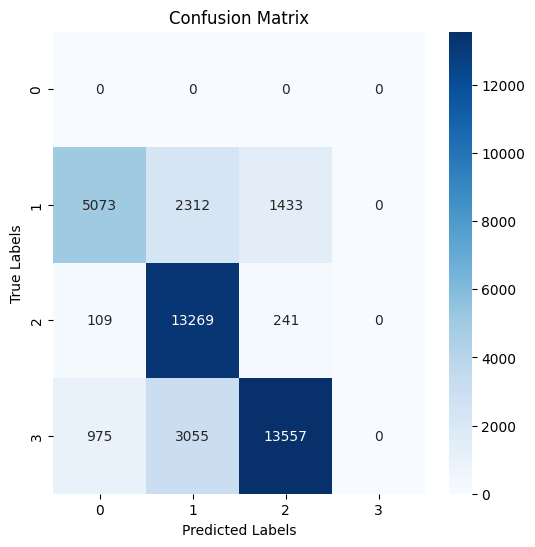

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test_binary, y_pred)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", ax=ax)

# Set labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Set x-axis tick labels
ax.xaxis.set_ticklabels(["-1", "0", "1"])

# Set y-axis tick labels
ax.yaxis.set_ticklabels(["-1", "0", "1"])

# Show the plot
plt.show()


In [61]:
def labelling(data):
    max_indices = np.argmax(data, axis=1)
    labels = np.zeros(data.shape[0], dtype=int)
    labels[max_indices == 0] = -1
    labels[max_indices == 1] = 0
    labels[max_indices == 2] = 1
    return labels[0]

In [46]:
save_model = model.save("Sentiment_model_1")

INFO:tensorflow:Assets written to: Sentiment_model_1\assets


INFO:tensorflow:Assets written to: Sentiment_model_1\assets


In [55]:
text="I feel sad"
loaded_model = tf.keras.models.load_model("Sentiment_model_1")
text = np.array([text])
value = loaded_model.predict(text)
l = labelling(value)
print(l)

1/1 [==============================] - 2s 2s/step
-1


In [51]:
text="I feel alright"
loaded_model = tf.keras.models.load_model("Sentiment_model_1")
text = np.array([text])
value = loaded_model.predict(text)
l = labelling(value)
print(l)

1/1 [==============================] - 2s 2s/step


array([0])

In [52]:
text="I feel happy"
loaded_model = tf.keras.models.load_model("Sentiment_model_1")
text = np.array([text])
value = loaded_model.predict(text)
l = labelling(value)
print(l)

1/1 [==============================] - 2s 2s/step


array([1])